# Training a DeepDive Model

This tutorial demonstrates how to train a **DeepDive** model on single-cell ATAC-seq data, monitor training progress, and perform reconstruction and counterfactual prediction.  

---




## Imports

In [1]:
import scanpy as sc
import DeepDive

In [2]:
from utils import reads_to_fragments

## 1. Load and preprocess the dataset
We start with an `AnnData` object containing single-cell chromatin accessibility profiles. Here we use a liver dataset (`sciatac3_liver_10k.h5ad`). It contains the 10k cells sampled from the [sciATAC-seq3](https://doi.org/10.1126/science.aba7612) dataset.

In [3]:
adata = sc.read_h5ad('data/sciatac3_liver_10k.h5ad')

In [4]:
min_cells = int(adata.shape[0] * 0.01)
sc.pp.filter_genes(adata, min_cells=min_cells)

In [5]:
adata.obs_names_make_unique()
reads_to_fragments(adata)
adata.X = adata.layers['fragments']


- **Gene filtering:** Remove features observed in fewer than 1% of cells.

- **Read conversion:** Convert raw read counts into approximate fragment counts using the provided utility function reads_to_fragments.

At this point, `adata` contains a filtered, fragment-based representation suitable for training.

## 2. Define model and training parameters

DeepDive consists of a conditional variational autoencoder with adversarial disentanglement.

**Model parameters**

- `n_decoders`: Number of decoders used for reconstruction.

- `n_epochs_pretrain_ae`: Number of epochs to pretrain the autoencoder before adversarial training begins.

**Training parameters**

- `max_epoch`: Maximum number of training epochs.

- `batch_size`: Number of cells per training batch.

- `shuffle`: Whether to shuffle the training dataset each epoch.

In [6]:
n_decoders = 1  
model_params = {
    'n_epochs_pretrain_ae' : 200*n_decoders,
    'n_decoders' : n_decoders,
}
train_params = {
    'max_epoch' : 300*n_decoders, 
    'batch_size' : 1024, 
    'shuffle' : True
}

## 3. Specify covariates

DeepDive disentangles known covariates (both discrete and continuous) from biological variation. These are specified as column names in `adata.obs`.

In [7]:
discrete_covriate_keys = ['sample_name', 'sex', 'batch', 'cell_type']
continuous_covriate_keys = ['day_of_pregnancy']

## 4. Initialize and train the model

The model is initialized with the AnnData object and covariate specifications, then trained using the defined parameters.

In [8]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )

In [9]:
model.train_model(adata, None, 
                  **train_params)

Epoch Train [300 / 300]: 100%|██████████| 10/10 [00:00<00:00, 10.08it/s, ETA=01d:00h:04:m22s|01d:00h:04:m22s, kl_loss=3.04, recon_loss=3.19e+3]


Training history (loss curves) can be visualized with:

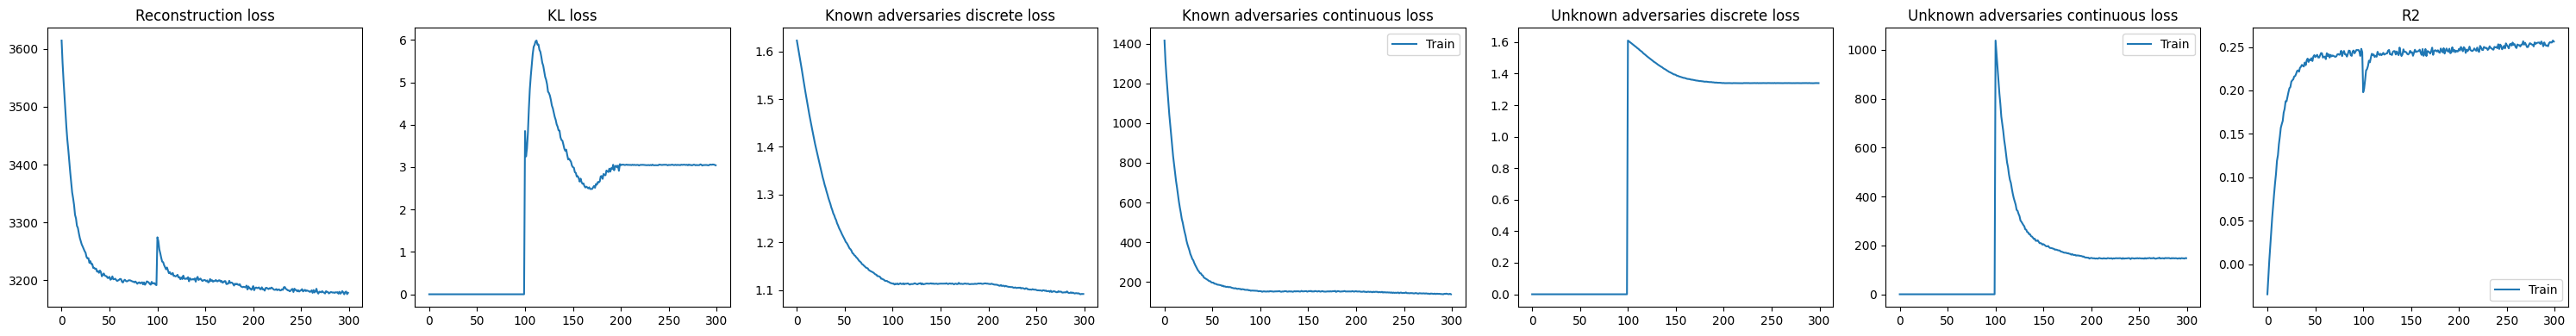

In [10]:
DeepDive.plot_history(model)

## 5. Save and reload the trained model

Trained models can be saved to disk and reloaded for downstream analysis.

In [11]:
model.save('model')

DeepDIVE model saved at: model


In [12]:
model = DeepDive.DeepDive(adata = adata, 
                        discrete_covariate_names = discrete_covriate_keys,
                        continuous_covariate_names = continuous_covriate_keys, 
                        **model_params
                       )
model = model.load(adata, 'model')

## 6. Reconstruction and counterfactual prediction

DeepDive can reconstruct the input data from latent representations and predict counterfactuals by altering covariates.

Reconstruction (with all covariates):

In [13]:
recon = model.predict(adata)

Counterfactual reconstruction (e.g., omitting covariates):

In [14]:
recon_subset = model.predict(adata, covars_to_add = ['cell_type'])

## 7. Getting latent representation

Latent representations from DeepDive can be computed using the `get_latent` method. To compute latent representations of only the residuals, an empty list can be passed to `covars_to_add`.

In [15]:
residual = model.get_latent(adata, covars_to_add = [])

In [16]:
sc.pp.neighbors(residual)
sc.tl.umap(residual)

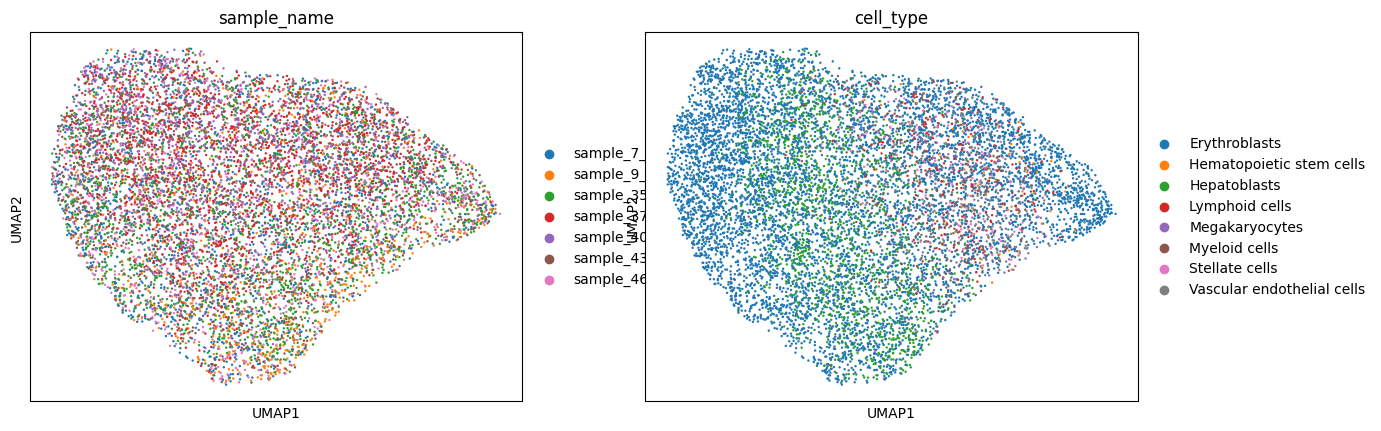

In [17]:
sc.pl.umap(residual, color = ['sample_name', 'cell_type'])

## Summary

This notebook covers the complete workflow of:

Preparing a dataset for DeepDive

- Defining model and training parameters

- Specifying covariates to disentangle

- Training and monitoring the model

- Saving and reloading models

- Performing reconstruction and counterfactual prediction